# Clustering of Cities having similar environment 

1. Data Understanding and Cleaning
2. Data Preparation
3. Modelling

In [1]:
#import all the necessary libraries

import pandas as pd
import numpy as np
import pandas as pd

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# To Scale our data
from sklearn.preprocessing import scale

# To perform KMeans clustering 
from sklearn.cluster import KMeans

# To perform Hierarchical clustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# Data Understanding

In [2]:
# read the dataset
# The data set has been taken from data.gov.in
dat = pd.read_csv('datafile.csv')
dat.head()

,Station_Name,Month,Mean_temperature_in_degree_C_Maximum,Mean_temperature_in_degree_C_Minimum,Mean_Rainfall_in_mm
0,Abu,January,19.3,8.0,5.3
1,Abu,February,21.0,10.0,4.4
2,Abu,March,25.3,14.5,6.5
3,Abu,April,29.4,18.7,2.6
4,Abu,May,31.5,21.0,16.4


In [3]:
dat.shape

(1331, 5)

In [4]:
#basic data checks
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1331 entries, 0 to 1330
Data columns (total 5 columns):
Station_Name                            1331 non-null object
Month                                   1331 non-null object
Mean_temperature_in_degree_C_Maximum    1331 non-null float64
Mean_temperature_in_degree_C_Minimum    1331 non-null float64
Mean_Rainfall_in_mm                     1331 non-null float64
dtypes: float64(3), object(2)
memory usage: 52.1+ KB


In [5]:
#basic data cleaning checks
dat.isna().sum()

Station_Name                            0
Month                                   0
Mean_temperature_in_degree_C_Maximum    0
Mean_temperature_in_degree_C_Minimum    0
Mean_Rainfall_in_mm                     0
dtype: int64

In [6]:
# Number of unique cities 

len(dat['Station_Name'].unique().tolist())

111

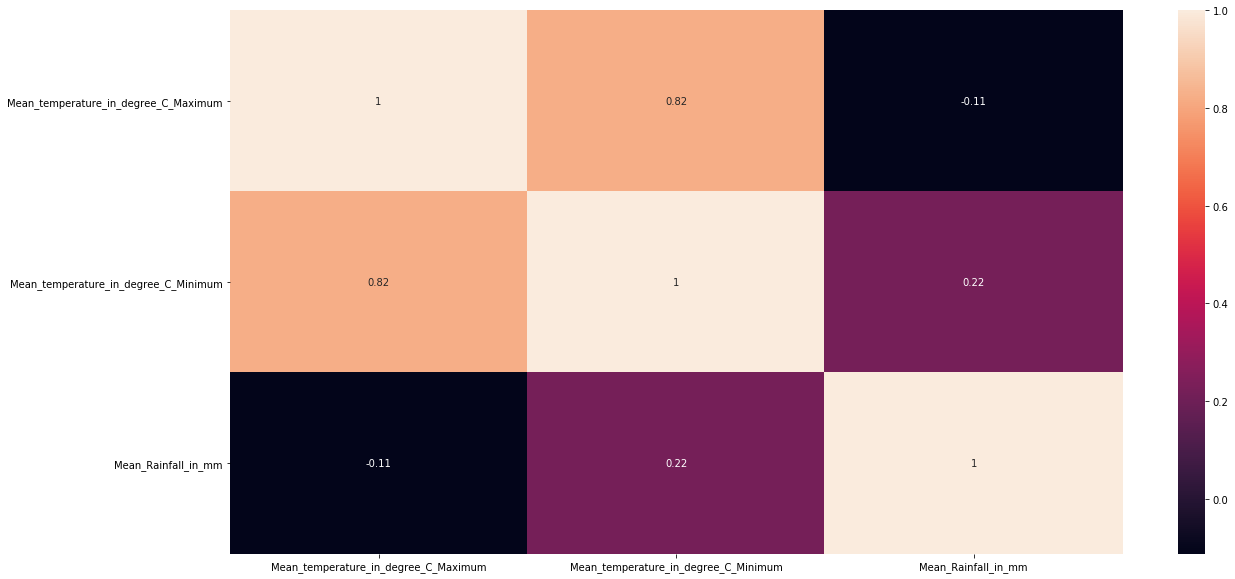

In [7]:
# data seems largely clean.
#ploting the correlation matrix and check if the data is indeed highly correlated
plt.figure(figsize = (20,10))        
sns.heatmap(dat.corr(),annot = True)

In [8]:
#The Mean _temperature_in_degree_C _Maximum  is highly correlated with Mean_temperature_in_degree_C _Minimum 
#  droping one of the feature "Mean_temperature_in_degree_C _Minimum"
datm=dat.drop(['Mean_temperature_in_degree_C_Minimum'],axis=1)
datm.head()

,Station_Name,Month,Mean_temperature_in_degree_C_Maximum,Mean_Rainfall_in_mm
0,Abu,January,19.3,5.3
1,Abu,February,21.0,4.4
2,Abu,March,25.3,6.5
3,Abu,April,29.4,2.6
4,Abu,May,31.5,16.4


### Dummy Variables
The variable `month` has 12 levels. We need to convert these levels into integer as well. For this, we will use something called `dummy variables`.

In [9]:
# Get the dummy variables for the feature 'fueltype' and store it in a new variable - 'status'

status = pd.get_dummies(datm['Month'])

# Check what the dataset 'status' looks like
status.head()

,April,August,December,February,January,July,June,March,May,November,October,September
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0


Now, you don't need 12 columns. You can drop any one  column, as month can be identified with just the last 11 columns

In [10]:
# droping the first column from status df using 'drop_first = True'
status = pd.get_dummies(datm['Month'], drop_first = True)

# Add the results to the original housing dataframe
datm = pd.concat([datm, status], axis = 1)

#  head of our dataframe.
datm.head()

,Station_Name,Month,Mean_temperature_in_degree_C_Maximum,Mean_Rainfall_in_mm,August,December,February,January,July,June,March,May,November,October,September
0,Abu,January,19.3,5.3,0,0,0,1,0,0,0,0,0,0,0
1,Abu,February,21.0,4.4,0,0,1,0,0,0,0,0,0,0,0
2,Abu,March,25.3,6.5,0,0,0,0,0,0,1,0,0,0,0
3,Abu,April,29.4,2.6,0,0,0,0,0,0,0,0,0,0,0
4,Abu,May,31.5,16.4,0,0,0,0,0,0,0,1,0,0,0


# Outlier treatment


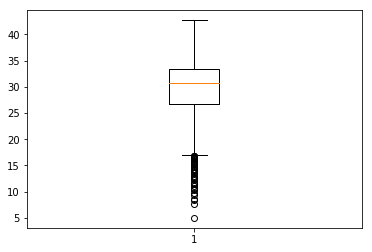

In [11]:

plt.boxplot(datm.Mean_temperature_in_degree_C_Maximum)
Q1 = datm.Mean_temperature_in_degree_C_Maximum.quantile(0.25)
Q3 = datm.Mean_temperature_in_degree_C_Maximum.quantile(0.75)
IQR = Q3 - Q1
datm = datm[(datm.Mean_temperature_in_degree_C_Maximum >= Q1 - 1.5*IQR) & (datm.Mean_temperature_in_degree_C_Maximum <= Q3 + 1.5*IQR)]

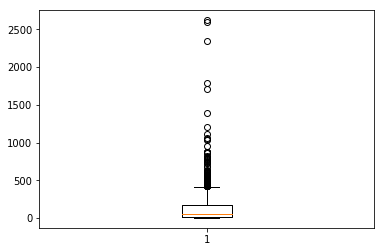

In [12]:
plt.boxplot(datm.Mean_Rainfall_in_mm)
Q1 = datm.Mean_Rainfall_in_mm.quantile(0.25)
Q3 = datm.Mean_Rainfall_in_mm.quantile(0.75)
IQR = Q3 - Q1
datm = datm[(datm.Mean_Rainfall_in_mm >= Q1 - 1.5*IQR) & (datm.Mean_Rainfall_in_mm <= Q3 + 1.5*IQR)]

## Clustering
As we checked previously the dataset looks of similar magnitude. Hence no further standardisation is necessary. Let's proceed to calculating the Hopkins statistic to ensure that the data is good for clustering.

## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [13]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [14]:
#Let's check the Hopkins measure
hopkins(datm.drop(['Station_Name','Month'],axis=1))

0.7493929571771981

In [15]:
#0.73 is a good Hopkins score. Hence the data is suitable for clustering. Preliminary check is now done.
# standardisation 
dat3 = datm
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
dat3_1 = standard_scaler.fit_transform(dat3.drop(['Station_Name','Month'],axis=1))

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [16]:
dat3.columns

Index(['Station_Name', 'Month', 'Mean_temperature_in_degree_C_Maximum',
       'Mean_Rainfall_in_mm', 'August', 'December', 'February', 'January',
       'July', 'June', 'March', 'May', 'November', 'October', 'September'],
      dtype='object')

### K-means Clustering

In [17]:
#Let's check the silhouette score first to identify the ideal number of clusters
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(dat3_1)
    sse_.append([k, silhouette_score(dat3_1, kmeans.labels_)])

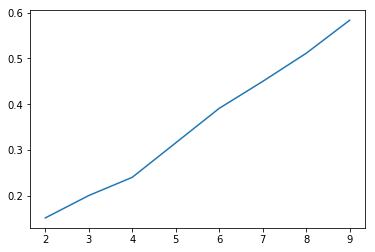

In [18]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

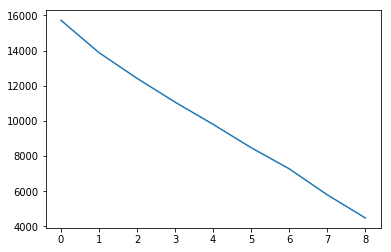

In [19]:
#The sihouette score reaches a peak at around 6 clusters indicating that it might be the ideal number of clusters.
#Let's use the elbow curve method to identify the ideal number of clusters.
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(dat3_1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [20]:
#A distinct elbow is formed at around 3-7 clusters. Let's finally create the clusters and see for ourselves which ones fare better
#K-means with k=6 clusters
model_clus5 = KMeans(n_clusters = 6, max_iter=50)
model_clus5.fit(dat3_1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [21]:
dat4=dat3
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus5.labels_)], axis=1)
dat_km.columns = ['Station_Name','Month', 'Mean_temperature_in_degree_C_Maximum',
       'Mean_Rainfall_in_mm', 'August', 'December', 'February', 'January',
       'July', 'June', 'March', 'May', 'November', 'October', 'September','ClusterID']
dat_km.head()

,Station_Name,Month,Mean_temperature_in_degree_C_Maximum,Mean_Rainfall_in_mm,August,December,February,January,July,June,March,May,November,October,September,ClusterID
0,Abu,January,19.3,5.3,0,0,0,1,0,0,0,0,0,0,0,1
1,Abu,February,21.0,4.4,0,0,1,0,0,0,0,0,0,0,0,1
2,Abu,March,25.3,6.5,0,0,0,0,0,0,1,0,0,0,0,2
3,Abu,April,29.4,2.6,0,0,0,0,0,0,0,0,0,0,0,1
4,Abu,May,31.5,16.4,0,0,0,0,0,0,0,1,0,0,0,0


In [22]:
dat_km['ClusterID'].value_counts()

1    512
0    203
5    196
3    110
2    105
4     84
Name: ClusterID, dtype: int64

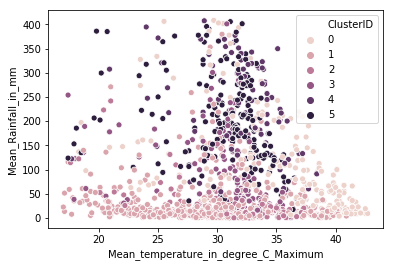

In [23]:
#Each cluster has a good number of city associated with it(at least 5% of the dataset under consideration)
#Let's do some further visualizations.
#We'll be visualising the clusters on the original principal components
sns.scatterplot(x='Mean_temperature_in_degree_C_Maximum',y='Mean_Rainfall_in_mm',hue='ClusterID',legend='full',data=dat_km)

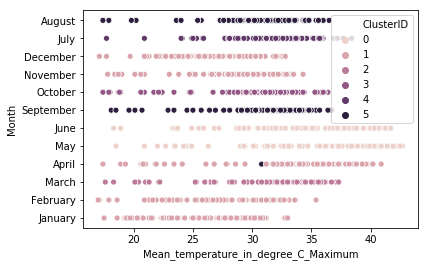

In [24]:
sns.scatterplot(x='Mean_temperature_in_degree_C_Maximum',y='Month',hue='ClusterID',legend='full',data=dat_km)

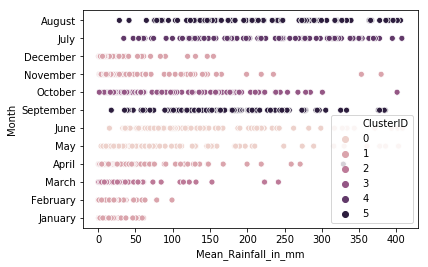

In [25]:
sns.scatterplot(x='Mean_Rainfall_in_mm',y='Month',hue='ClusterID',legend='full',data=dat_km)

In [26]:

#let's take a look at those city clusters and try to make sense if the clustering process worked well.
# city in cluster 0
cluster0=dat_km[dat_km['ClusterID']==0]
# As there are repeated values in the feature station_Name
cluster0[['Station_Name','Month']]

,Station_Name,Month
4,Abu,May
5,Abu,June
14,Agartala (A),May
15,Agartala (A),June
26,Agra,May
27,Agra,June
38,Ahmedabad,May
39,Ahmedabad,June
50,Aijal/Aizwal,May
51,Aijal/Aizwal,June


In [27]:
# city in cluster 1
cluster1=dat_km[dat_km['ClusterID']==1]
cluster1[['Station_Name','Month']]

,Station_Name,Month
0,Abu,January
1,Abu,February
3,Abu,April
8,Abu,November
9,Abu,December
10,Agartala (A),January
11,Agartala (A),February
13,Agartala (A),April
20,Agartala (A),November
21,Agartala (A),December


In [28]:
# city in cluster 2
cluster2=dat_km[dat_km['ClusterID']==2]
cluster2[['Station_Name','Month']]

,Station_Name,Month
2,Abu,March
12,Agartala (A),March
24,Agra,March
36,Ahmedabad,March
48,Aijal/Aizwal,March
60,Ajmer,March
72,Akola (A),March
84,Allahabad,March
96,Ambikapur,March
107,Amini Divi,March


In [29]:
# city in cluster 3
cluster3=dat_km[dat_km['ClusterID']==3]
cluster3[['Station_Name','Month']]

,Station_Name,Month
7,Abu,October
19,Agartala (A),October
31,Agra,October
43,Ahmedabad,October
55,Aijal/Aizwal,October
67,Ajmer,October
79,Akola (A),October
91,Allahabad,October
102,Ambikapur,October
114,Amini Divi,October


In [30]:
# city in cluster 4
cluster4=dat_km[dat_km['ClusterID']==4]
cluster4[['Station_Name','Month']]

,Station_Name,Month
16,Agartala (A),July
28,Agra,July
40,Ahmedabad,July
52,Aijal/Aizwal,July
64,Ajmer,July
76,Akola (A),July
88,Allahabad,July
111,Amini Divi,July
123,Amritsar (Rajasansi),July
135,Anantpur,July


In [31]:
# city in cluster 5
cluster5=dat_km[dat_km['ClusterID']==5]
cluster5[['Station_Name','Month']]

,Station_Name,Month
6,Abu,September
17,Agartala (A),August
18,Agartala (A),September
29,Agra,August
30,Agra,September
41,Ahmedabad,August
42,Ahmedabad,September
53,Aijal/Aizwal,August
54,Aijal/Aizwal,September
65,Ajmer,August


## Hierarchical Clustering
Let's check if hierarchical clustering does a good job.

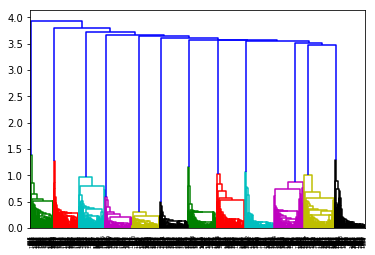

In [32]:
#Let's try hierarchical clustering to see if it works well
#First we'll try the single linkage procedure.
mergings = linkage(dat3_1, method = "single", metric='euclidean')
dendrogram(mergings)
plt.show()

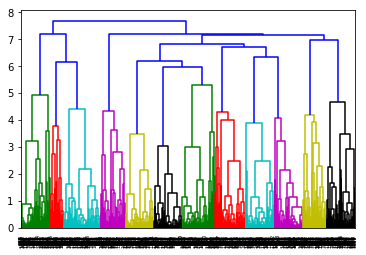

In [33]:
#We do get good results here.
#Let's try complete linkage method
mergings = linkage(dat3_1, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [34]:
#Okay now we are seeing some good clusters here. Let's see if they make sense if we eliminate the barriers
clusterCut = pd.Series(cut_tree(mergings, n_clusters = 6).reshape(-1,))
dat3_hc = pd.concat([dat3, clusterCut], axis=1)
dat3_hc.columns = ['Station_Name','Month', 'Mean_temperature_in_degree_C_Maximum',
       'Mean_Rainfall_in_mm', 'August', 'December', 'February', 'January',
       'July', 'June', 'March', 'May', 'November', 'October', 'September','ClusterID']

In [35]:
dat3_hc.head()

,Station_Name,Month,Mean_temperature_in_degree_C_Maximum,Mean_Rainfall_in_mm,August,December,February,January,July,June,March,May,November,October,September,ClusterID
0,Abu,January,19.3,5.3,0,0,0,1,0,0,0,0,0,0,0,0
1,Abu,February,21.0,4.4,0,0,1,0,0,0,0,0,0,0,0,0
2,Abu,March,25.3,6.5,0,0,0,0,0,0,1,0,0,0,0,0
3,Abu,April,29.4,2.6,0,0,0,0,0,0,0,0,0,0,0,1
4,Abu,May,31.5,16.4,0,0,0,0,0,0,0,1,0,0,0,2


In [36]:
dat3_hc['ClusterID'].value_counts()

0    641
1    182
2    108
3    104
5     91
4     84
Name: ClusterID, dtype: int64

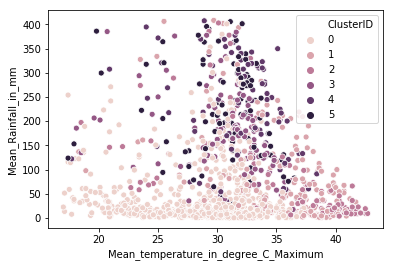

In [37]:
#Each cluster has a good number of city associated with it(at least 5% of the dataset under consideration)
#Let's do some further visualizations.
#We'll be visualising the clusters on the original principal components
sns.scatterplot(x='Mean_temperature_in_degree_C_Maximum',y='Mean_Rainfall_in_mm',hue='ClusterID',legend='full',data=dat3_hc)

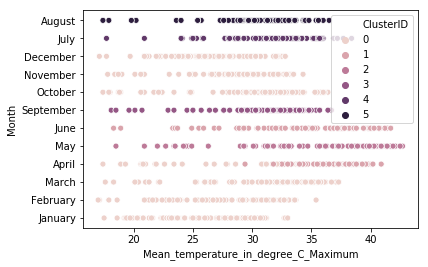

In [38]:
sns.scatterplot(x='Mean_temperature_in_degree_C_Maximum',y='Month',hue='ClusterID',legend='full',data=dat3_hc)

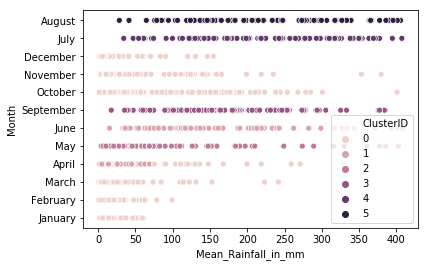

In [39]:
sns.scatterplot(x='Mean_Rainfall_in_mm',y='Month',hue='ClusterID',legend='full',data=dat3_hc)

In [40]:
#let's take a look at those city clusters and try to make sense if the clustering process worked well.
# city in cluster 0
cluster0=dat3_hc[dat3_hc['ClusterID']==0]
# As there are repeated values in the feature station_Name
cluster0[['Station_Name','Month']]

,Station_Name,Month
0,Abu,January
1,Abu,February
2,Abu,March
7,Abu,October
8,Abu,November
9,Abu,December
10,Agartala (A),January
11,Agartala (A),February
12,Agartala (A),March
13,Agartala (A),April


In [41]:
# city in cluster 1
cluster1=dat3_hc[dat3_hc['ClusterID']==1]
# As there are repeated values in the feature station_Name
cluster1[['Station_Name','Month']]

,Station_Name,Month
3,Abu,April
5,Abu,June
15,Agartala (A),June
25,Agra,April
27,Agra,June
37,Ahmedabad,April
39,Ahmedabad,June
51,Aijal/Aizwal,June
61,Ajmer,April
63,Ajmer,June


In [42]:
# city in cluster 2
cluster2=dat3_hc[dat3_hc['ClusterID']==2]
# As there are repeated values in the feature station_Name
cluster2[['Station_Name','Month']]

,Station_Name,Month
4,Abu,May
14,Agartala (A),May
26,Agra,May
38,Ahmedabad,May
50,Aijal/Aizwal,May
62,Ajmer,May
74,Akola (A),May
86,Allahabad,May
98,Ambikapur,May
109,Amini Divi,May


In [43]:
# city in cluster 3
cluster3=dat3_hc[dat3_hc['ClusterID']==3]
# As there are repeated values in the feature station_Name
cluster3[['Station_Name','Month']]

,Station_Name,Month
6,Abu,September
18,Agartala (A),September
30,Agra,September
42,Ahmedabad,September
54,Aijal/Aizwal,September
66,Ajmer,September
78,Akola (A),September
90,Allahabad,September
101,Ambikapur,September
113,Amini Divi,September


In [44]:
# city in cluster 4
cluster4=dat3_hc[dat3_hc['ClusterID']==4]
# As there are repeated values in the feature station_Name
cluster4[['Station_Name','Month']]

,Station_Name,Month
16,Agartala (A),July
28,Agra,July
40,Ahmedabad,July
52,Aijal/Aizwal,July
64,Ajmer,July
76,Akola (A),July
88,Allahabad,July
111,Amini Divi,July
123,Amritsar (Rajasansi),July
135,Anantpur,July


In [45]:
# city in cluster 5
cluster5=dat3_hc[dat3_hc['ClusterID']==5]
# As there are repeated values in the feature station_Name
cluster5[['Station_Name','Month']]

,Station_Name,Month
17,Agartala (A),August
29,Agra,August
41,Ahmedabad,August
53,Aijal/Aizwal,August
65,Ajmer,August
77,Akola (A),August
89,Allahabad,August
100,Ambikapur,August
112,Amini Divi,August
124,Amritsar (Rajasansi),August


# Result
From the data set of 1331 row and 5 feature 6 clusters where generated with corresponding values it’s clear on analysis that city varies in temperature and rainfall on monthly basis. Thus we can find month as a common factor in each cluster.